In [21]:
import pandas as pd
import numpy as np
import time, random
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import KFold

from torch.utils.data import DataLoader
from utils.myModel import *
from utils.loader import *
from pytorch_ranger import Ranger
from torch.utils.tensorboard import SummaryWriter

In [22]:
# one of the top used feature engineering functions from kaggle users
def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    return df

In [37]:
class dummyArgs():
    def __init__(self,boot_seed=1):
        self.n_Tlayer = 16
        self.n_head = 16
        self.n_Elayer = 4
        self.Etype = "GRU"
        self.use_conv = False
        self.dropout = 0
        self.largefs = True
        self.bootstrap = False
        self.bootstrap_seed = boot_seed
args = dummyArgs(0)
trial_name = f"T{args.n_Tlayer}h{args.n_head}{args.Etype}{args.n_Elayer}"
trial_name += "conv" if args.use_conv else ""
trial_name += f"_dropout{args.dropout:.2f}"
trial_name += "_largefs" if args.largefs else ""
trial_name += f"_embd256_boot{args.bootstrap_seed}" if args.bootstrap else ""
print("loading model from trial ",trial_name)

loading model from trial  T16h16GRU4_dropout0.00_largefs


In [24]:
print("Loading data...")
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
masks=np.array(train['u_out']==0).reshape(-1, 80) 
targets = train[['pressure']].to_numpy().reshape(-1, 80)

if not args.largefs:
    print("No feature engineering, One hot encoding...")
    for dset in ('train','test'):
        df = eval(dset)
        df['R'] = df['R'].astype(str)
        df['C'] = df['C'].astype(str)
        df = pd.get_dummies(df)
        exec(f'{dset}=df')
else:
    print('feature engineering...')
    train = add_features(train)
    test = add_features(test)
    
print("Dropping id and labels...")
train.drop(['pressure', 'id', 'breath_id'], axis=1, inplace=True)
test = test.drop(['id', 'breath_id'], axis=1)

print("Normalizing...")
RS = RobustScaler()
train = RS.fit_transform(train)
test = RS.transform(test)

print("Reshaping...")
train = train.reshape(-1, 80, train.shape[-1])
test = test.reshape(-1, 80, train.shape[-1])

print('train:',train.shape)
print('test:',test.shape)

kf = KFold(n_splits=10,shuffle=True,random_state=0) # forbid random_state, make some randomness between models in different runs

Loading data...
feature engineering...
Dropping id and labels...
Normalizing...
Reshaping...
train: (75450, 80, 50)
test: (50300, 80, 50)


In [25]:
val_features=[train[i] for i in list(kf.split(train))[0][1]]
val_targets=[targets[i] for i in list(kf.split(targets))[0][1]]
val_masks=[masks[i] for i in list(kf.split(targets))[0][1]]

In [26]:
val_dataset = TrainDataset(val_features,val_targets,val_masks)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)
del val_features

In [27]:
print("init model...")
model = MyModel(in_dim = train.shape[-1], out_dim = 1,embd_dim=256,
                n_transformer_layers=args.n_Tlayer, nheads = args.n_head, dropout=args.dropout,
                n_rnn_layers=args.n_Elayer, rnn_type = args.Etype,use_conv = args.use_conv).cuda()

init model...


In [38]:
model.load_state_dict(torch.load(f'{trial_name}.pt'))

<All keys matched successfully>

In [39]:
criterion = nn.L1Loss(reduction='none')
model.eval()
val_metric=[]
val_loss=0
t=time.time()
preds=[]
truths=[]
masks=[]
for step,batch in enumerate(val_dataloader):
    features,targets,mask=batch
    features=features.cuda()
    targets=targets.cuda()
    mask=mask.cuda()
    with torch.no_grad():
        output=model(features)

        loss=criterion(output,targets)
        loss=torch.masked_select(loss,mask)
        loss=loss.mean()
        val_loss+=loss.item()
        preds.append(output.cpu())
        truths.append(targets.cpu())
        masks.append(mask.cpu())
    
preds=torch.cat(preds).numpy()
truths=torch.cat(truths).numpy()
masks=torch.cat(masks).numpy()

In [40]:
preds.shape,truths.shape,masks.shape,val_loss/(step+1)

((7545, 80), (7545, 80), (7545, 80), 0.16398366831116756)

In [41]:
np.save(f'boot{args.bootstrap_seed}.out',preds)
np.save('masks',masks)
np.save('truths',truths)

# load saved outputs and do simple average ensemble

In [49]:
import numpy as np
model_list = [1,2,3,4,5,6,7,8,9,0]
#model_list = [2,1,6,0,9,3,4,5,7,8]
masks = np.load('masks.npy')
truths = np.load('truths.npy')

In [50]:
avg_out = 0
for model_id in model_list:
    model_out = np.load(f'boot{model_id}.out.npy')
    avg_out += model_out
    err = (np.abs(model_out-truths)*masks).sum()/masks.sum()
    print(model_id,err)

1 0.16272490364926695
2 0.16055767727879988
3 0.16542185780913005
4 0.1657856118421627
5 0.1672920470942518
6 0.1631120904752757
7 0.1686609383322564
8 0.16881780502060723
9 0.16416533823991689
0 0.1639511686517119


In [44]:
avg_out /= len(model_list)
err = (np.abs(avg_out-truths)*masks).sum()/masks.sum()
print(err)

0.15241764686460363


In [57]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=(8,6)
ensemble_res = []
for n in range(1,11):
    avg_out = 0
    for model_id in model_list[:n]:
        model_out = np.load(f'boot{model_id}.out.npy')
        avg_out += model_out
    avg_out /= len(model_list[:n])
    err = (np.abs(avg_out-truths)*masks).sum()/masks.sum()
    print(n,err)
    ensemble_res.append(err)

1 0.16272490364926695
2 0.1550026557165373
3 0.15383834947455968
4 0.15329139670633846
5 0.1533416049614488
6 0.1526957364732412
7 0.15275788283248778
8 0.15296014842542546
9 0.1526185822116518
10 0.15241764686460363


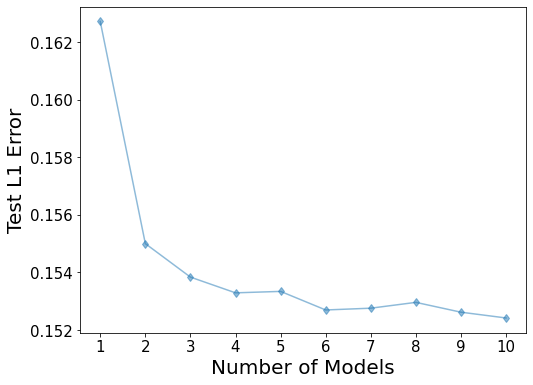

In [65]:
plt.plot(range(1,11),ensemble_res,marker='d',alpha=0.5)
plt.xlabel('Number of Models',fontsize=20)
plt.ylabel('Test L1 Error',fontsize=20)
plt.xticks(range(1,11),fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('ensemble.pdf',bbox_inches='tight')
plt.show()

In [56]:
ensemble_res

[0.16272490364926695,
 0.1550026557165373,
 0.15383834947455968,
 0.15329139670633846,
 0.1533416049614488,
 0.1526957364732412,
 0.15275788283248778,
 0.15296014842542546,
 0.1526185822116518,
 0.15241764686460363]